#### 1. Importing the required packages

In [203]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import xgboost

#### 2. Changing the working directory

In [204]:
os.chdir('C:/Users/Indium Software/Documents/MEGA/Simplilearn/Project')

#### 3. Reading Train and Test data

In [208]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### 4. Preparation for removing columns with zero variance # Not Used

In [31]:
#train.dtypes[train.dtypes=='float64'or train.dtypes == 'int64']
varcs = train.var(axis=0)
varcs = varcs[varcs == 0]
to_drop = list(varcs.index)
dt = train.drop(to_drop, axis=1)
print("The variables {} have been dropped as they have zero variance".format(to_drop))

The variables ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347'] have been dropped as they have zero variance


#### 5. Function for removing columns with zero variance

In [209]:
# drops the variables with zero variance in a given dataset
def drop_zerovarcs(data):
    varcs = data.var(axis=0)
    varcs = varcs[varcs == 0]
    to_drop = list(varcs.index)
    #data_new = data.drop(to_drop, axis=1)
    print("The variables {} have been dropped as they have zero variance".format(to_drop))
    return to_drop

#### 6. Getting list of zero variance columns in train and test datasets

In [210]:
test_drops = drop_zerovarcs(test)
train_drops = drop_zerovarcs(train)
test_train_drop = [x for x in train_drops if x not in test_drops]

The variables ['X257', 'X258', 'X295', 'X296', 'X369'] have been dropped as they have zero variance
The variables ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347'] have been dropped as they have zero variance


#### Not used

In [ ]:
# drops columns from test where variance is zero in test data as well as the columns for which variance is zero in train data
# train and test have different columns which have zero variance
# Hence dropping the same columns in train and test data. Dropping the columns with zero variance in train data from test data.
test.drop(test_train_drop, axis=1,inplace=True)

#### 7. Remove zero variance columns in train data from test data

In [212]:
# drop the columns in test for which varaince is zero in train data
train.drop(train_drops, axis=1,inplace=True)
#len(list(train.drop(train_drops,axis=1).columns))
test.drop(train_drops,axis=1,inplace=True)
#len(list(test.drop(train_drops,axis=1).columns))

#### 8. Finding Unique, Total Count and NAs and writing it to a csv

In [213]:
# Find Unique, Total Count and NAs 
def uni_ct_na(data):
    unique = data.apply(lambda x: x.nunique(), axis=0)
    count = data.apply(lambda x: x.count(), axis=0)
    null = data.isnull().sum()
    na = data.isna().sum()
    summary_df = pd.DataFrame([unique, count, null, na],index=['Unique', 'Count', 'Null', 'NA'])
    summary_df.T.to_csv('summary_df.csv')

In [214]:
uni_ct_na(train)

#### 9. Finding the list of categorical variables

In [215]:
#Finding the list of categorical variables
obj = list(train.dtypes[train.dtypes=='object'].index)

#### 10. Label Encoding Categorical variables in train and test datasets

In [216]:
#Label Encoding categorical variables
for cols in obj:
    le = preprocessing.LabelEncoder()
    train[cols+'_le'] = le.fit_transform(train[cols])
train.drop(obj,axis=1,inplace=True)

for cols in obj:
    le = preprocessing.LabelEncoder()
    test[cols+'_le'] = le.fit_transform(test[cols])
test.drop(obj,axis=1,inplace=True)

#### 11. Deleting categorical variables from train and test

In [217]:
# Keeping only numeric variables to apply PCA
train_cols = train.columns
train_not_obj = [x for x in train_cols if x not in obj]
train = train[train_not_obj]

test_cols = test.columns
test_not_obj = [x for x in test_cols if x not in obj]
test = test[test_not_obj]

#### 12. Plotting Scree plot to get the number of components which will explain 90% variance in data

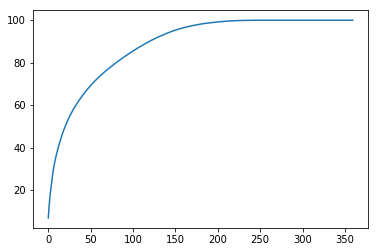

In [218]:
# PLotting Scree plot to get the number of components which will explain 90% variance in data
X=train.iloc[:,1:].values
X = scale(X)
pca = PCA(n_components=360)
pca.fit(X)
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)


#### 13. Performing PCA on train and test data

In [219]:
# Performing PCA on train and test data
X=train.iloc[:,1:].values
X = scale(X)
pca = PCA(n_components=150)
pca.fit(X)
train_pca = pca.transform(X)
train_pca.shape

X_test=train.iloc[:,1:].values
X_test = scale(X)
test_pca = pca.transform(X_test)

#### 14.Separating x and y variables to be passed to xgboost

In [220]:
# Separating x and y variables to be passed to xgboost
train_y = train_pca[:,1]
train_x = train_pca[:,2:]
test_y = test_pca[:,1]
test_x = test_pca[:,2:]

#### 15. Defining xgboost model

In [221]:
# Fitting a xgboost model with default options
model = xgboost.XGBRegressor() 
model.fit(train_x, train_y)

C:\Users\Indium Software\Anaconda2\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[22:38:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

#### 16. Predict from the xgboost model

In [222]:
# Predict from the model on test data
pred_y = model.predict(test_x)

In [189]:
test_y

array([-2.93283525,  0.44568795, 21.43457786, ...,  0.72800715,
        0.69375157, -1.12324901])

#### 17. Calculating Root Mean Square Error

In [223]:
# Calculating Root Mean Square Error
rmse = np.sqrt(np.sum((pred_y-test_y)**2)/len(pred_y))
rmse

0.6012976548070404